In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Steel_industry_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [4]:
df.shape

(35040, 11)

In [5]:
df.isna().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

# Data Preprocessing

In [6]:
df.columns = df.columns.str.lower()
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in string_columns:
    df[c] = df[c].str.lower()

In [7]:
df.date = pd.to_datetime(df.date, format="%d/%m/%Y %H:%M")
df.date = df.date.dt.to_period('M')
df.date = df.date.apply(str)
#removing hours and minutes from date column.
#changing datetime object to string object again.

In [8]:
df.head()

,date,usage_kwh,lagging_current_reactive.power_kvarh,leading_current_reactive_power_kvarh,co2(tco2),lagging_current_power_factor,leading_current_power_factor,nsm,weekstatus,day_of_week,load_type
0,2018-01,3.17,2.95,0.0,0.0,73.21,100.0,900,weekday,monday,light_load
1,2018-01,4.00,4.46,0.0,0.0,66.77,100.0,1800,weekday,monday,light_load
2,2018-01,3.24,3.28,0.0,0.0,70.28,100.0,2700,weekday,monday,light_load
3,2018-01,3.31,3.56,0.0,0.0,68.09,100.0,3600,weekday,monday,light_load
4,2018-01,3.82,4.50,0.0,0.0,64.72,100.0,4500,weekday,monday,light_load


# EDA

I used violinplot to get an idea of the relations between target variable and numerical features.

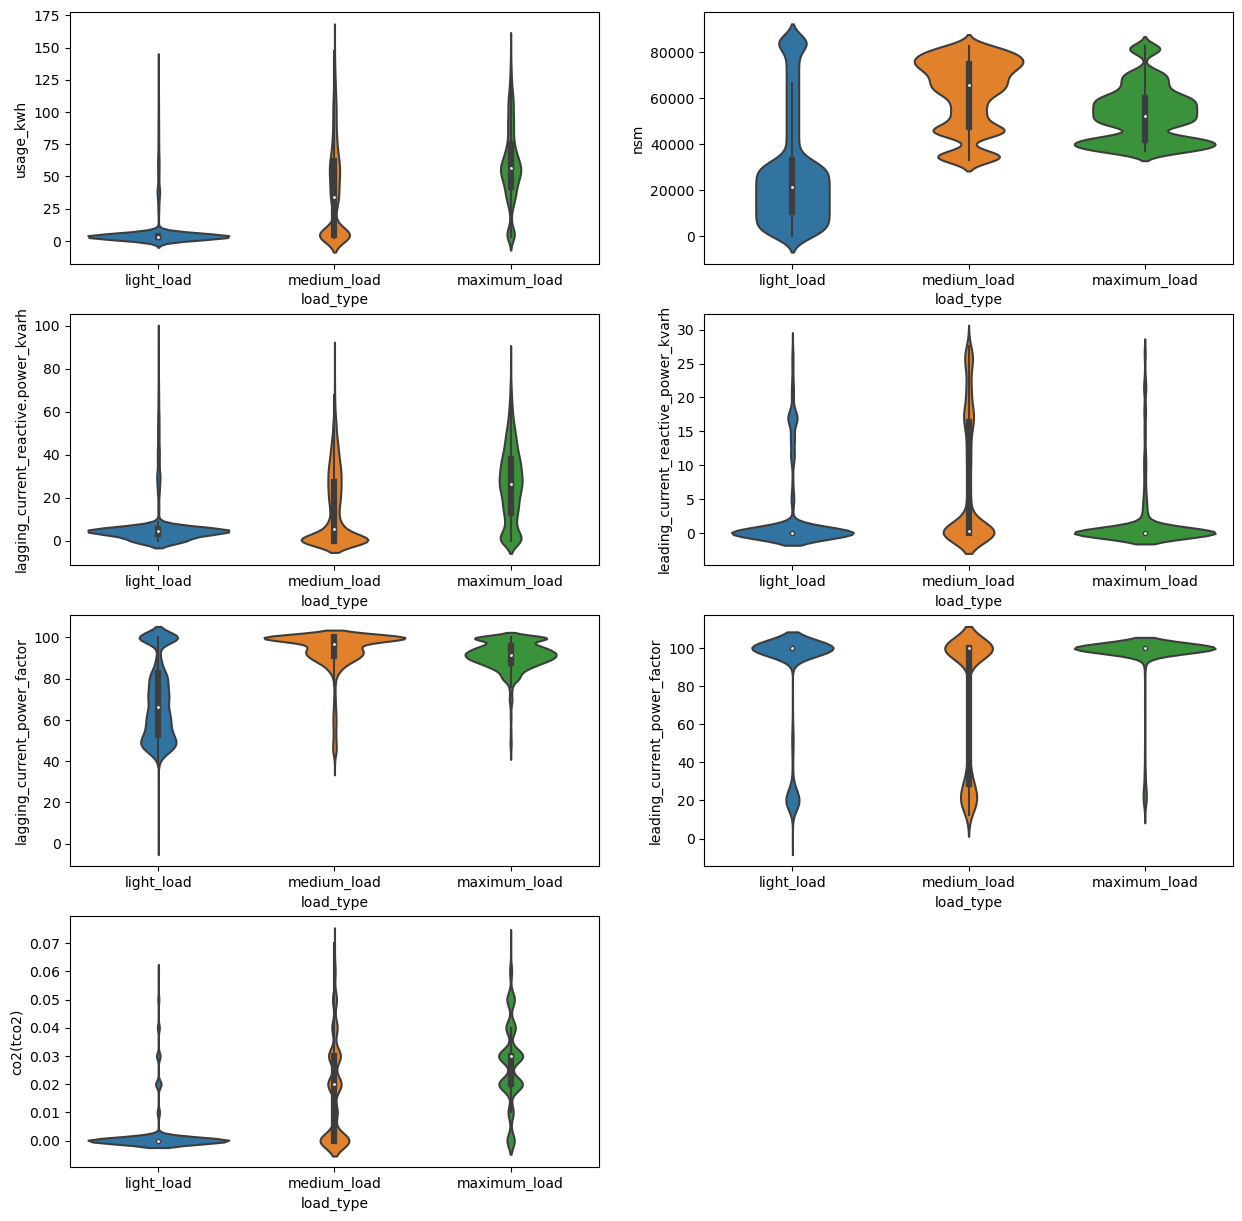

In [9]:
numerical = ['usage_kwh', 'nsm', 
             'lagging_current_reactive.power_kvarh','leading_current_reactive_power_kvarh', 
             'lagging_current_power_factor', 'leading_current_power_factor', 
             'co2(tco2)']
plt.figure(figsize = (15,15))
for i,n in enumerate(numerical):
    ax = plt.subplot(4, 2, i+1)
    sns.violinplot(df, x = 'load_type', y = n, ax = ax)

All numerical features seems to have effects on load type and among them, 'usage_kwh','nsm','lagging_current_reactive.power_kvarh' seems to have stronger effects than other features.

<Axes: xlabel='day_of_week', ylabel='count'>

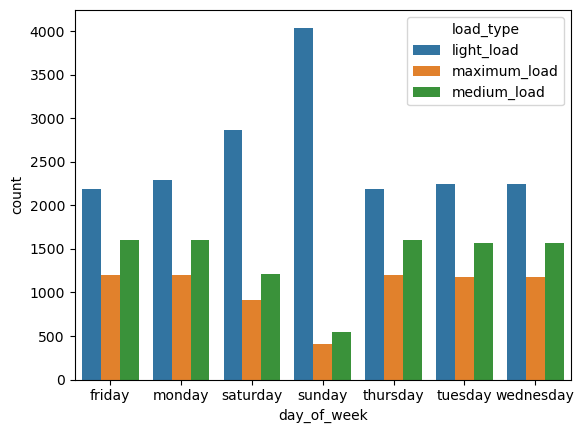

In [10]:
grouped = df.groupby(['day_of_week', 'load_type']).size().reset_index(name='count')
sns.barplot(grouped, x = 'day_of_week', y = 'count', hue = 'load_type')

It seems like all weekdays have very similar distribution of load types. It means that this feature might be reducdant since we also have week status feature.

In [11]:
del df['day_of_week']

# Data Modelling

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [13]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.load_type
y_val = df_val.load_type
y_test = df_test.load_type

In [16]:
feature_columns = list(df.dtypes.index)[:-1]

In [17]:
train_dict = df_train[feature_columns].to_dict(orient = 'records')
val_dict = df_val[feature_columns].to_dict(orient = 'records')
test_dict = df_test[feature_columns].to_dict(orient = 'records')

In [18]:
dv = DictVectorizer(sparse = False)

In [19]:
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Logistic Regression

In [20]:
lr = LogisticRegression(max_iter = 2000, random_state = 1, multi_class = 'multinomial')
lr.fit(X_train,y_train)

LogisticRegression(max_iter=2000, multi_class='multinomial', random_state=1)

In [21]:
df.load_type.value_counts(normalize = True)

load_type
light_load      0.515753
medium_load     0.276712
maximum_load    0.207534
Name: proportion, dtype: float64

In [22]:
y_pred = lr.predict_proba(X_val)

In [23]:
#method to check macro f1 score and macro auc score. 
#Class distribution is a bit unbalanced, so, I will focus on macro score.
def f1_score_and_auc_score(y_val, y_pred):
    scores = []
    t = 0.5
    light_load_actual_positive = (y_val == 'light_load')
    light_load_actual_negative = (y_val != 'light_load')

    medium_load_actual_positive = (y_val == 'medium_load')
    medium_load_actual_negative = (y_val != 'medium_load')

    maximum_load_actual_positive = (y_val == 'maximum_load')
    maximum_load_actual_negative = (y_val != 'maximum_load')

    light_load_predictive_positive = (y_pred[:,0] >= t)
    light_load_predictive_negative = (y_pred[:,0] < t)

    medium_load_predictive_positive = (y_pred[:,2] >= t)
    medium_load_predictive_negative = (y_pred[:,2] < t)

    maximum_load_predictive_positive = (y_pred[:,1] >=t)
    maximum_load_predictive_negative = (y_pred[:,1] < t)

    l_l_tp = (light_load_predictive_positive & light_load_actual_positive).sum()
    l_l_tn = (light_load_predictive_negative & light_load_actual_negative).sum()
    l_l_fp = (light_load_predictive_positive & light_load_actual_negative).sum()
    l_l_fn = (light_load_predictive_negative & light_load_actual_positive).sum()

    med_l_tp = (medium_load_predictive_positive & medium_load_actual_positive).sum()
    med_l_tn = (medium_load_predictive_negative & medium_load_actual_negative).sum()
    med_l_fp = (medium_load_predictive_positive & medium_load_actual_negative).sum()
    med_l_fn = (medium_load_predictive_negative & medium_load_actual_positive).sum()

    max_l_tp = (maximum_load_predictive_positive & maximum_load_actual_positive).sum()
    max_l_tn = (maximum_load_predictive_negative & maximum_load_actual_negative).sum()
    max_l_fp = (maximum_load_predictive_positive & maximum_load_actual_negative).sum()
    max_l_fn = (maximum_load_predictive_negative & maximum_load_actual_positive).sum()

    l_l_precision = l_l_tp/(l_l_tp + l_l_fp)
    l_l_recall = l_l_tp/(l_l_tp + l_l_fn)
        
    med_l_precision = med_l_tp/(med_l_tp + med_l_fp)
    med_l_recall = med_l_tp/(med_l_tp + med_l_fn)
        
    max_l_precision = max_l_tp/(max_l_tp + max_l_fp)
    max_l_recall = max_l_tp/(max_l_tp + max_l_fn)
        
    l_l_f1_score = (2 * l_l_precision * l_l_recall)/(l_l_precision + l_l_recall)
    med_l_f1_score = (2 * med_l_precision * med_l_recall)/(med_l_precision + med_l_recall)
    max_l_f1_score = (2 * max_l_precision * max_l_recall)/(max_l_precision+ max_l_recall)
    
    light_load_auc = roc_auc_score(light_load_actual_positive, light_load_predictive_positive)
    medium_load_auc = roc_auc_score(medium_load_actual_positive, medium_load_predictive_positive)
    maximum_load_auc = roc_auc_score(maximum_load_actual_positive, maximum_load_predictive_positive)
    
    macro_avg_f1_score = (l_l_f1_score + med_l_f1_score + max_l_f1_score)/3
    macro_avg_auc = (light_load_auc + medium_load_auc + maximum_load_auc)/3
    return macro_avg_f1_score, macro_avg_auc 

In [24]:
macro_avg_f1_score, macro_avg_auc = f1_score_and_auc_score(y_val, y_pred)

In [25]:
print('macro_avg_f1_score = %.3f, macro_avg_auc = %.3f' %(macro_avg_f1_score, macro_avg_auc) )

macro_avg_f1_score = 0.635, macro_avg_auc = 0.741


In [26]:
scores = []
for C in tqdm([0.001, 0.01, 0.1, 1.0, 10.0]):
    lr = LogisticRegression(C = C, max_iter = 2000, solver = 'lbfgs', random_state = 1, multi_class = 'multinomial')
    lr.fit(X_train,y_train)
    macro_avg_f1_score, macro_avg_auc = f1_score_and_auc_score(y_val, y_pred)
    scores.append((C, macro_avg_f1_score, macro_avg_auc))
score_df = pd.DataFrame(scores, columns = ['C', 'macro_avg_f1_score', 'macro_avg_auc'])

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.09s/it]


In [27]:
score_df

,C,macro_avg_f1_score,macro_avg_auc
0,0.001,0.635148,0.740561
1,0.010,0.635148,0.740561
2,0.100,0.635148,0.740561
3,1.000,0.635148,0.740561
4,10.000,0.635148,0.740561


The accuracy of logistic regression is not that good. So, I will try with random forest classifier for better results.

# Random Forest Classifier

In [28]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

Text(0.5, 1.0, 'Feature Importance Chart')

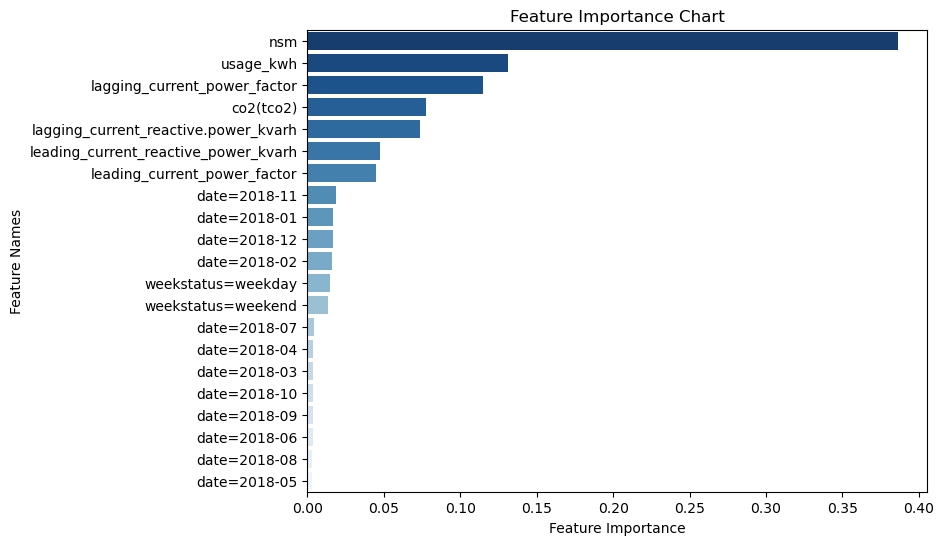

In [29]:
#feature importance in random forest classifier
features_names = list(dv.get_feature_names_out())
feature_importances = list(zip(features_names, rf.feature_importances_))

importance_df = pd.DataFrame(feature_importances, columns=['feature_names', 'feature_importances'])

importance_df = importance_df.sort_values(by='feature_importances', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='feature_importances', y='feature_names', data=importance_df, palette='Blues_r')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance Chart')

In [30]:
y_pred = rf.predict_proba(X_val)

In [31]:
scores = []
for n in range(10 ,201, 10):
    rf = RandomForestClassifier(n_estimators = n, random_state = 1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)
    macro_avg_f1_score, macro_avg_auc = f1_score_and_auc_score(y_val, y_pred)
    scores.append((n, macro_avg_f1_score, macro_avg_auc))

In [32]:
score_df = pd.DataFrame(scores, columns = ['n', 'macro_avg_f1_score', 'macro_avg_auc'])

In [33]:
score_df[(score_df.macro_avg_auc == score_df.macro_avg_auc.max()) | 
         (score_df.macro_avg_f1_score == score_df.macro_avg_f1_score.max())]

,n,macro_avg_f1_score,macro_avg_auc
15,160,0.975526,0.980359


The scores are high, but the model is overfitting since we have unlimited maximum depth.

In [34]:
scores = []
for d in tqdm([3,5,7,10]):
    for n in range(10 ,201, 10):
        rf = RandomForestClassifier(max_depth = d, n_estimators = n, random_state = 1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)
        macro_avg_f1_score, macro_avg_auc = f1_score_and_auc_score(y_val, y_pred)
        scores.append((d, n, macro_avg_f1_score, macro_avg_auc))
score_df = pd.DataFrame(scores, columns = ['d','n', 'macro_avg_f1_score', 'macro_avg_auc'])

100%|█████████████████████████████████████████████| 4/4 [01:02<00:00, 15.59s/it]


In [35]:
score_df[(score_df.macro_avg_auc == score_df.macro_avg_auc.max()) |
         (score_df.macro_avg_f1_score == score_df.macro_avg_f1_score.max())].round(3)

,d,n,macro_avg_f1_score,macro_avg_auc
76,10,170,0.934,0.946


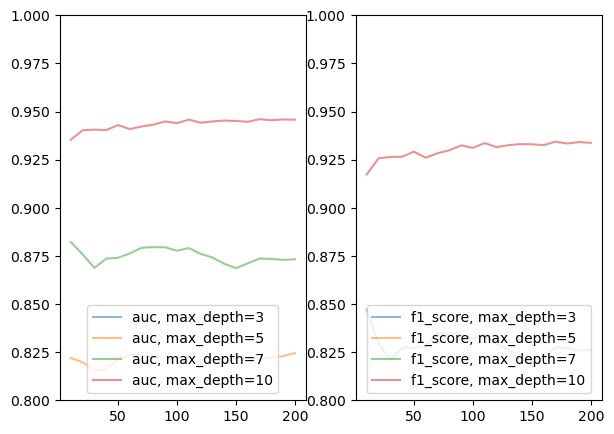

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7,5))
plt.ylim(0.80, 1)
for d in [3,5,7,10]:
    df_subset = score_df[score_df.d == d]
    ax1.plot(df_subset.n, df_subset.macro_avg_auc, label = 'auc, max_depth=%d'%d, alpha = 0.5)
    ax2.plot(df_subset.n, df_subset.macro_avg_f1_score, label = 'f1_score, max_depth=%d'%d, alpha = 0.5)
    ax1.legend(loc = 8)
    ax2.legend(loc = 8)
    ax1.set_ylim([0.80, 1])
    ax2.set_ylim([0.80, 1])

In [37]:
max_depth = 10
#max_depth 10 obviously have better scores than other values.

In [38]:
scores = []
for s in tqdm([1, 3, 5, 10, 50]):
    for n in range(10 ,201, 10):
        rf = RandomForestClassifier(max_depth = max_depth, n_estimators = n, min_samples_leaf = s, random_state = 1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)
        macro_avg_f1_score, macro_avg_auc = f1_score_and_auc_score(y_val, y_pred)
        scores.append((n, s, macro_avg_f1_score, macro_avg_auc))
score_df = pd.DataFrame(scores, columns = ['n','min_samples_leaf', 'macro_avg_f1_score', 'macro_avg_auc'])

100%|█████████████████████████████████████████████| 5/5 [01:39<00:00, 19.89s/it]


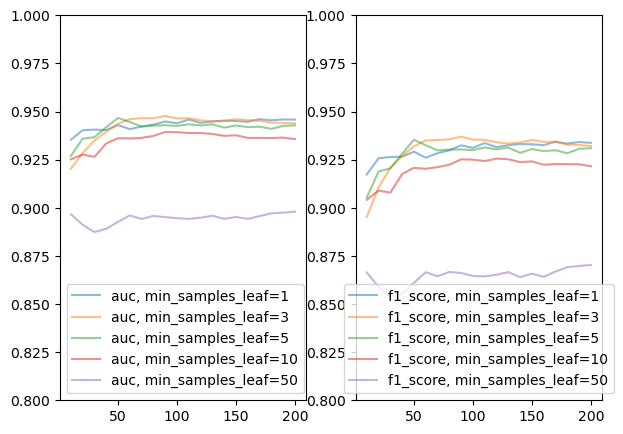

In [39]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7,5))
plt.ylim(0.80, 1)
for s in [1, 3, 5, 10, 50]:
    df_subset = score_df[score_df.min_samples_leaf == s]
    ax1.plot(df_subset.n, df_subset.macro_avg_auc, label = 'auc, min_samples_leaf=%d'%s, alpha = 0.5)
    ax2.plot(df_subset.n, df_subset.macro_avg_f1_score, label = 'f1_score, min_samples_leaf=%d'%s, alpha = 0.5)
    ax1.legend()
    ax2.legend(loc = 8)
    ax1.set_ylim([0.80, 1])
    ax2.set_ylim([0.80, 1])

In [40]:
score_df[(score_df.macro_avg_auc == score_df.macro_avg_auc.max()) |
         (score_df.macro_avg_f1_score == score_df.macro_avg_f1_score.max())].round(3)

,n,min_samples_leaf,macro_avg_f1_score,macro_avg_auc
28,90,3,0.937,0.948


I choose max_depth = 10, n_estimators = 90, min_samples_leaf = 3 as my parameters since they give best score.

In [41]:
max_depth = 10
n_estimators = 90
min_samples_leaf = 3
feature_columns = list(df.dtypes.index)[:-1]
def train(df_train, y_train, max_depth, n_estimators, min_samples_leaf):
    dicts = df_train[feature_columns].to_dict(orient = 'records')
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    rf = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, 
                                min_samples_leaf = min_samples_leaf, random_state = 1)
    rf.fit(X_train, y_train)
    return dv, rf

In [42]:
df_full_train = df_full_train.reset_index(drop = True)
y_full_train = df_full_train.load_type
dv, model = train(df_full_train, y_full_train, max_depth, n_estimators, min_samples_leaf)

In [43]:
def predict(df,dv,model):
    dicts = df[feature_columns].to_dict(orient = 'records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)
    return y_pred

In [44]:
y_pred = predict(df_test, dv, model)

In [45]:
macro_avg_f1_score, macro_avg_auc = f1_score_and_auc_score(y_test, y_pred)
print('macro_avg_f1_score= %.3f ,macro_avg_auc = %.3f' %(macro_avg_f1_score,macro_avg_auc) )

macro_avg_f1_score= 0.934 ,macro_avg_auc = 0.946


Accuracy score on test data is 94.6%. So, the model does well on the test data.